In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad, Function
import numpy as np
import math

In [2]:
def ode_solve(y0, t0, t1, func):
    h_max = 0.05
    n_steps = math.ceil(abs(t1-t0)/h_max)

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.lin1 = nn.Linear(8, 16)
        self.lin2 = nn.Linear(16, 16)
        self.lin3 = nn.Linear(16, 2)

    def forward(self, x):
        x = F.leaky_relu(self.lin1(x))
        x = F.leaky_relu(self.lin2(x))
        x = self.lin3(x)
        return x
model = Model()



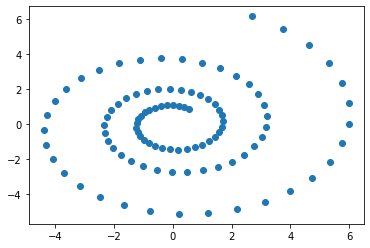

In [3]:
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import numpy as np 

t0 = 1
t1 = 20
z0 = np.array([np.cos(t0), np.sin(t0)])

def dzdt(t, z):
    dzdt = np.array([
        [1/10, -1.0],
        [1.0, 1/10],
    ]) @ z
    return dzdt 

t_eval = np.linspace(t0, t1, 100)
sol = solve_ivp(dzdt, (t0, t1), z0, t_eval=t_eval)
plt.plot(sol.y[0], sol.y[1], 'o')

In [147]:
def odeint(func, t, y0, t_eval):
    # explicit Euler
    assert t[0]==t_eval[0] and t_eval[-1]==t[1]
    n_items = len(y0)
    y = [
        torch.zeros((len(t_eval), *item.shape)) for item in y0
    ]

    for i in range(n_items):
        y[i][0] += y0[i]

    for i in range(1, len(t_eval)):
        dt = t_eval[i]-t_eval[i-1]
        state = [y[j][i-1] for j in range(n_items)]

        dydt = func(t_eval[i], state if n_items>1 else state[0])
        
        for j in range(n_items):
            y[j][i] = y[j][i-1] + dydt[j] * dt
    return y

In [148]:
class AdjointMethod(Function):
    @staticmethod
    def forward(ctx, func, t, y0, t_eval, parameters):
        ctx.func = func
        ctx.t_eval = t_eval
        with torch.no_grad():
            y = odeint(func, t, (y0,), t_eval=t_eval)
        
        ctx.save_for_backward(t, *y, *parameters)
        return tuple(y)

    @staticmethod
    def backward(ctx, grad_y):
        
        func = ctx.func
        t_eval = ctx.t_eval
        t, y, *parameters = ctx.saved_tensors

        def aug_dynamics(t, y_aug):
            y = y_aug[1]
            adj_y = y_aug[2]

            with torch.enable_grad():
                func_eval = func(t, y)
                vjp_t, vjp_y, *vjp_p = grad(
                    outputs=func_eval,
                    inputs=(t, y) + tuple(*parameters()),
                    grad_outputs=-adj_y,
                    allow_unused=True,
                    retain_graph=True
                )

            return func_eval, vjp_y, vjp_p, vjp_t
        
        aug_state  = [
            torch.zeros(()), # vjp_t
            y[-1], # y
            grad_y[-1] # vjp_y
        ] + [
            torch.zeros_like(param) for param in parameters
        ]

        aug_state = solve_ivp(
            fun=aug_dynamics,
            t_span=t.flip(0),
            y0=aug_state,
            t_eval=t_eval.flip(0),
        )

        adj_y = aug_state[2]
        adj_p = aug_state[3:]

        # func, t, y0, t_eval, parameters
        return None, None, adj_y, None, adj_p


In [149]:
class LinearODEF(nn.Module):
    def __init__(self):
        super(LinearODEF, self).__init__()
        self.lin = nn.Linear(2, 2)
    
    def forward(self, t, yt):
        return self.lin(yt)

class NeuralODE(nn.Module):
    def __init__(self, func):
        super(NeuralODE, self).__init__()
        assert isinstance(func, nn.Module)
        self.func = func
    
    def forward(self, t, y0, t_eval):
        result = AdjointMethod.apply(self.func, t, y0, t_eval, self.func.parameters())
        return result


In [157]:
func = LinearODEF()
model = NeuralODE(func)

<ipython-input-158-f82e82e03d86>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_eval = torch.tensor(t_eval)


tensor(5.9806, grad_fn=<MseLossBackward>)

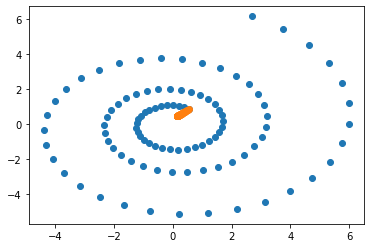

In [158]:
y0 = torch.from_numpy(z0).type(torch.float32).requires_grad_(True)
t = torch.tensor([t0, t1], dtype=torch.float32, requires_grad=True)
t_eval = torch.tensor(t_eval)
y_pred = model(t=t, y0=y0, t_eval=t_eval)[0].T
y = solve_ivp(dzdt, (t0, t1), z0, t_eval=t_eval).y

plt.plot(y[0], y[1], 'o')
plt.plot(y_pred[0].detach(), y_pred[1].detach(), 'o')

loss = F.mse_loss(y_pred, torch.from_numpy(y).type(torch.float32))
loss

In [159]:
loss.backward()

RuntimeError: No grad accumulator for a saved leaf!